In [1]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [ ]:
service = QiskitRuntimeService(name='rpi-quantum')
backend = service.backend('ibm_rensselaer')

### Creating a Parameterized Circuit
In the next cell, you will need to create a Bell state using a Hadamard and CX gate as we have done in previous exercises. In order to continuously vary the measurement basis, we also need to add an $R_y$ gate to the first qubit. $R_y$ represents an arbitrary rotation around the Y-axis by an angle $\theta$.

In the original CHSH example, both Alice and Bob choose a measurement basis, which would imply that both qubits ought to have a rotation gate. The reason we only need one $R_y$ gate is because that is only the *relative phase difference* between Alice and Bob's basis choices that matters. Thus, it is sufficient to apply an $R_y$ gate to only a single qubit, while holding the basis fixed for the other one.

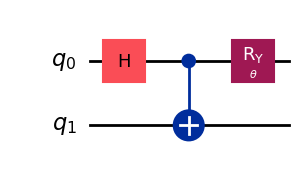

In [210]:
# Create a Parameter to hold the angle values we'll be
# varying
theta = circuit.Parameter("$\\theta$")

chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0,1)

# Add an Ry gate to the circuit that rotates qubit 0
# by the angle theta that you defined in the parameter. 
chsh_circuit.ry(theta, 0)

chsh_circuit.draw(output="mpl", idle_wires=False, style="iqp")

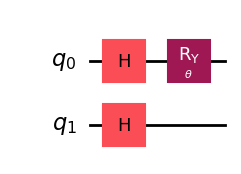

In [211]:
hadamard_circuit = QuantumCircuit(2)

# 1. YOUR CODE GOES HERE - Add a Hadamard gate to each qubit.
hadamard_circuit.h(0)
hadamard_circuit.h(1)

# 2. YOUR CODE GOES HERE - Add an Ry gate to the circuit that rotates qubit 0
# by the angle theta that you defined in the parameter. You can reuse the same
# parameter as in the previous cell 
hadamard_circuit.ry(theta, 0)

hadamard_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### Creating a Grid of Parameters
Now that we have parameterized circuits, we need to create the actual parameters that will fill the placeholders we created. Running the next cell will create a grid of $\theta$ values that runs from $0$ to $2\pi$, in increments of $\frac{pi}{12}$. Then it puts the individual values into a "list of lists" format needed by Qiskit.

In [212]:
# DO NOT MODIFY - Create a grid of parameters
number_of_phases = 25
phases = np.linspace(0, 2*np.pi, number_of_phases)

# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

### Observables for Alice and Bob
The measurement bases chosen by Alice and Bob depend on the input they see. We use $A$ and $B$ to denote their chosen bases if they see a red card, and $a$ and $b$ their choices if they see a black card. In the tutorial example, these correspond to Alice and Bob's basis choices when they see a 0, or 1, respectively.

We define a value, $S$, called the *CHSH witness*, which is given by:

$$S_1 = \langle A \otimes B\rangle - \langle A \otimes b \rangle + \langle a \otimes B\rangle + \langle a \otimes b\rangle$$
and
$$S_2 = \langle A \otimes B\rangle + \langle A \otimes b \rangle - \langle a \otimes B\rangle + \langle a \otimes b\rangle$$

The angle brackets $\langle \cdot \rangle$ denote an **expectation value**. 

**Note**: In some references (including the Qiskit tutorial), the tensor product notation $\otimes$ is implied when showing the tensor product of observables.
$$S_1 = \langle AB\rangle - \langle Ab \rangle + \langle aB\rangle + \langle ab\rangle$$
and
$$S_2 = \langle AB\rangle + \langle Ab \rangle - \langle aB\rangle + \langle ab\rangle$$

are the same as above.

In the CHSH experiment, Alice and Bob perform measurements based on their inputs, and we're interested in the average behavior over many trials. To implement this efficiently on the hardware:

1. We apply an $R_y(\theta)$ rotation to Alice's qubit. This rotation changes her measurement basis relative to Bob's. By varying $\theta$, we can see the impact on their wining probability as a function of measurement choices.
2. The sum of operator expectation values is equal to the expectation value of the sum of the operators:
$$\langle A + B \rangle = \langle A \rangle + \langle B\rangle$$
This allows us to define $S$ directly as an observable:

$$\langle\hat{S}\rangle = \langle A\otimes B \mp A\otimes b \pm a\otimes B + a\otimes b \rangle$$

Since we can only use $X$, $Y$ and $Z$ operators in `SparsePauliOp`, we have to format our observable in terms of those operators: 

- For Alice:
  - $A=Z$ (when she sees a red card)
  - $a=X$ (when she sees a black card)
- For Bob:
  - $B=Z$ (when he sees a red card)
  - $b=X$ (when he sees a black card)

This gives us a `SparsePauliOp` observable of:
$$\langle\hat{S}\rangle = \langle Z\otimes Z \mp Z\otimes X \pm X\otimes Z + X\otimes X \rangle$$

By applying $R_y(\theta)$ to Alice's qubit before measurement, we effectively change her measurement basis. The $S$ expectation value is then calculated using the measurement results of the Pauli observables, where the basis change induced by $R_y(\theta)$ is implied.

In [237]:
# Create the measurement observables for both S1 and S2 cases.

# <S1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
s1_observable = SparsePauliOp.from_list([("ZZ", 1),
                                         ("ZX", -1),
                                         ("XZ", 1),
                                         ("XX", 1)])

# <CS2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
s2_observable = SparsePauliOp.from_list([("ZZ", 1),
                                         ("ZX", 1),
                                         ("XZ", -1),
                                         ("XX", 1)])

### Transpilation

Now that the circuits and observables have been defined, we need to transpile the circuits and apply the observables.

**Task:** Run the cell to perform the transpilation and observable application operations. In the next blank cell below it, write a few sentences explaining what you think is happening here (what is the transpilation doing, what does it mean to apply the observable to your transpiled circuit?

In [238]:
# Transpile the circuits and observables.

# Create a pass manager to transpile our circuits and observables 
pm = generate_preset_pass_manager(target=backend.target,
                                  optimization_level=3)

# Run the transpiler on the base CHSH and Hadamard circuits we created.
isa_circuits = pm.run([chsh_circuit, hadamard_circuit])

# Run the transpiler on the observables and apply them to the base circuits we
# transpiled in the previous step.
isa_s1 = [s1_observable.apply_layout(layout=circuit.layout)
             for circuit in isa_circuits]
isa_s2 = [s2_observable.apply_layout(layout=circuit.layout)
           for circuit in isa_circuits]

### Preparing the Job
Once we have the circuits transpiled and observables applied, we need to create PUBs (primitive unified blocks) that bundle up all the circuits, observables and parameters we need to do our calculation.

In [239]:
# Create an Estimator and prepare the PUB objects for execution.
estimator = Estimator(mode=backend)

chsh_pub = (
    isa_circuits[0],  # ISA circuit
    [[isa_s1[0]], [isa_s2[0]]],  # ISA Observables
    individual_phases,  # Parameter values
)

hadamard_pub = (
    isa_circuits[1],  # ISA circuit
    [[isa_s1[1]], [isa_s2[1]]],  # ISA Observables
    individual_phases,  # Parameter values
)

### Running the Job
Run the cell below to submit your circuits to the machine. Since we created a grid of parameters for each case, the machine will need to run $G\cdot N$ circuits, where $G$ is the number of grid points in your parameter grid, and $N$ is the number of cases we're testing.

In [240]:
job = estimator.run(pubs=[chsh_pub, hadamard_pub])

print(f"Job ID: {job.job_id()}")

Job ID: cwa1a382802g0081p3wg


In [217]:
# Print the job status. The whole job should take ~5 minutes to
# run once it gets through the queue.
print(job.status())

RUNNING


### Retrieving the Results

Once the job is complete, we use the `result` function to get the full list of results for the set of PUBs we ran. We can get the result for individual PUBs by indexing into the list. (e.g., `job_result[0]` to get the first PUB result.)

From each PUB result, we then get the computed expectation values by accessing the `job_result.data.evs` list. Since each PUB had two cases (for $S_1$ and $S_2$), we need to access them separately.

In [241]:
# Retrieve the results. This will block until the job is completed.

job_result = job.result()

s1_est = job_result[0].data.evs[0]
s2_est = job_result[0].data.evs[1]

had1_est = job_result[1].data.evs[0]
had2_est = job_result[1].data.evs[1]
print(s1_est)
print(s2_est)
print(had1_est)
print(had2_est)

[ 1.97947948  1.37487487  0.70720721 -0.08458458 -0.76076076 -1.47597598
 -2.05105105 -2.47247247 -2.76026026 -2.82182182 -2.73023023 -2.5035035
 -1.9994995  -1.40540541 -0.69319319  0.02202202  0.76276276  1.46546547
  2.03603604  2.43393393  2.75325325  2.85785786  2.73323323  2.40790791
  1.99349349]
[ 2.03853854  2.47797798  2.74024024  2.85535536  2.74274274  2.44594595
  1.96796797  1.4014014   0.67317317 -0.06606607 -0.75825826 -1.40640641
 -2.00850851 -2.47447447 -2.76426426 -2.89289289 -2.71371371 -2.42942943
 -1.98998999 -1.46296296 -0.69419419  0.01201201  0.74224224  1.46696697
  2.01351351]
[ 0.9995015   0.62013958  0.32502493 -0.04087737 -0.37387836 -0.73629113
 -1.05084746 -1.27866401 -1.39780658 -1.37437687 -1.35044865 -1.25074776
 -0.96560319 -0.61914257 -0.33649053  0.0329013   0.37886341  0.7113659
  1.05932203  1.25074776  1.37387836  1.37986042  1.40628116  1.20787637
  0.99002991]
[ 1.0333998   1.27018943  1.3439681   1.40877368  1.40279163  1.15403789
  1.0279162

# Plotting the Results
Finally, we can plot the results of our CHSH $S$-values and the corresponding $S$-values for the unentangled Hadamard strategy as a function of the parameter $\theta$.

The gray band in the plot denotes the region where Bell's inequality is violated. Any $S$-values in this region signify that quantum entanglement gave the players an advantage over a strictly classical strategy. 

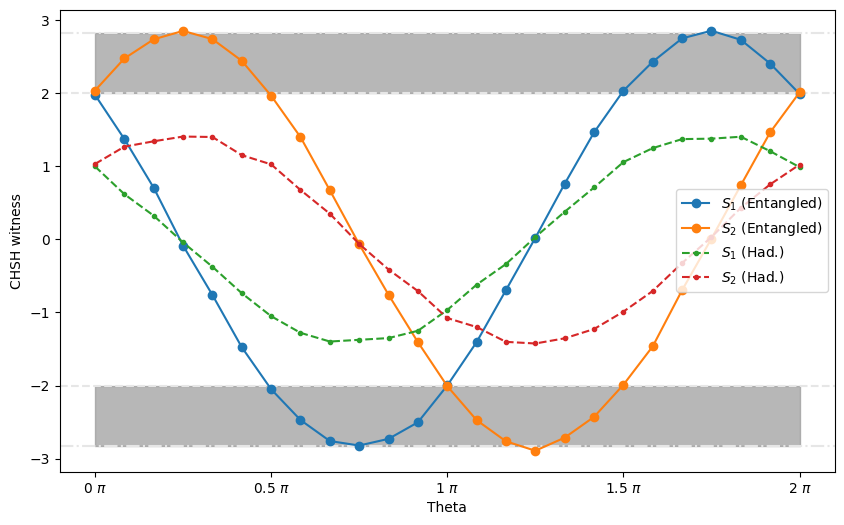

In [242]:
# Plot the Results

fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, s1_est, "o-", label="$S_1$ (Entangled)", zorder=3)
ax.plot(phases / np.pi, s2_est, "o-", label="$S_2$ (Entangled)", zorder=3)
ax.plot(phases / np.pi, had1_est, ".--", label="$S_1$ (Had.)", zorder=3)
ax.plot(phases / np.pi, had2_est, ".--", label="$S_2$ (Had.)", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

In [220]:
# Compute the winning probabilities for each case
def p_win(S):
    return 0.5 + S/8

print(f"P_win (Entangled S_1) = {max(p_win(s1_est))}")
print(f"P_win (Entangled S_2) = {max(p_win(s2_est))}")
print(f"P_win (non-entangled  S_1) = {max(p_win(had1_est))}")
print(f"P_win (non-entangled S_2) = {max(p_win(had1_est))}")

P_win (Entangled S_1) = 0.9998756218905472
P_win (Entangled S_2) = 0.9998756218905472
P_win (non-entangled  S_1) = 0.8759970089730807
P_win (non-entangled S_2) = 0.8759970089730807


Both cases are higher than the 75% success of the classic strategy.